In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.utils import np_utils
from matplotlib import pyplot as plt
%matplotlib inline

Using TensorFlow backend.
C:\Users\NOH\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\NOH\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\NOH\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\NOH\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: Fu

In [2]:
csvData=pd.read_csv('../데이터셋/fer2013/fer2013.csv') # csv 파일 읽어옴

In [3]:
data=csvData.values # csv파일에서 안에 데이터들만 가져옴
emotion=data[:,0] # 감정 라벨링 데이터
imagePixels=data[:,1] # 이미지 픽셀 데이터

In [4]:
imagePixels.shape[0] # 이미지 개수 35887
len(imagePixels[0]) # 0번째 이미지 픽셀 길이 8287

8287

In [5]:
reshapeImgPixels=np.zeros((imagePixels.shape[0],48*48)) # 행:이미지개수 / 열:48*48

for i in range(reshapeImgPixels.shape[0]): # 행(이미지개수)만큼
    onePixArr=imagePixels[i].split(' ') # 이미지 하나 가져와서 공백으로 split
    for j in range(reshapeImgPixels.shape[1]): # 열(48*48)만큼
        reshapeImgPixels[i,j]=int(onePixArr[j]) #reshapeImage에 픽셀 재배치      

In [6]:
# 이미지의 각 화소값이 0과 1사이의 값을 가지도록 정규화

img=reshapeImgPixels
img=img/255 

In [7]:
# 학습용 개수 28710
# private 테스트 개수 3590

img_train=img[0:28710,:] # 28710행 48*48열
img_priTest=img[28710:32300,:]

In [8]:
# 이미지 shape => (28710, 1, 48, 48)로 변경

img_train=img_train.reshape((img_train.shape[0],1,48,48)) 
img_priTest=img_priTest.reshape((img_priTest.shape[0],1,48,48))

In [9]:
# 감정 shape => (35887, 7)로 변경

oneHotEmotion=np_utils.to_categorical(emotion, 7) # 감정 데이터 원핫인코딩 

In [10]:
emotion_train=oneHotEmotion[0:28710]
emotion_priTest=oneHotEmotion[28710:32300]

In [11]:
# ImageDataGenerator를 이용하여 이미지 augmentation 수행

from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator( # 데이터 증가를 위한 클래스
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=10,  # 이미지 회전 범위
        zoom_range = 0.0,  
        width_shift_range=0.1,  # 이미지를 수평 or 수직으로 랜덤하게 평행 이동 시키는 범위
        height_shift_range=0.1,  
        horizontal_flip=True, 
        vertical_flip=False)  

datagen.fit(img_train) # data generator를 샘플 데이터에 fitting

C:\Users\NOH\anaconda3\lib\site-packages\keras\preprocessing\image.py:957: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (28710, 1, 48, 48) (48 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


In [12]:
#local minima에 빠질경우 learning rate를 조절하여 빠져나올 수 있도록 함

from keras.callbacks import ReduceLROnPlateau
reduceLR = ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.0001, patience=1, verbose=1)

C:\Users\NOH\anaconda3\lib\site-packages\keras\callbacks.py:928: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` insted.
  warnings.warn('`epsilon` argument is deprecated and '


In [13]:
#여기부터 신경망

In [24]:
from keras.models import Model
from keras.layers import Dense , Activation, concatenate, Multiply, Reshape, Permute
from keras.layers import Dropout
from keras.layers import Flatten
from keras import Input
from keras.constraints import maxnorm
from keras.optimizers import SGD , Adam
from keras.layers import SeparableConv2D, Conv2D, BatchNormalization
from keras.layers import AveragePooling2D, GlobalAveragePooling2D
from keras.models import Sequential
from keras import backend as K
K.set_image_dim_ordering('th')

In [27]:
# Dense Block

# Dense Block에 깊이별분리컨볼루션 있는 부분
def dense_first(x):
    x = Conv2D(filters=32, kernel_size=(1,1), padding="same")(x) # 1x1 Conv 
    x = SeparableConv2D(filters=32, kernel_size=(3,3), padding="same")(x) # Depthwise Sep Conv
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

# input_tensor로 dense_first가 들어감
"""
def SE_block(input_tensor): 
    ch_input = K.int_shape(input_tensor)[-1]
    ch_reduced = ch_input//16
    
    # Sqeeze
    x = GlobalAveragePooling2D()(input_tensor)
    
    # Excitation
    x = Dense(ch_reduced, kernel_initializer='he_normal', activation='relu', use_bias=False)(x)
    x = Dense(ch_input, kernel_initializer='he_normal', activation='sigmoid', use_bias=False)(x)
    
    x = Reshape( (1, 1, ch_input) )(x)
    x = Multiply()([input_tensor, x])
    
    return x
"""
#"""
def SE_block(input_tensor, ratio=16):
    init=input_tensor
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    filters = init._keras_shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    if K.image_data_format() == 'channels_first':
        se = Permute((3, 1, 2))(se)

    x = multiply([init, se])
    return x
#"""

# 최종 Dense Block
def dense_block(input_tensor):
    denseFirstResult = dense_first(input_tensor)
    SEBlockResult = SE_block(denseFirstResult)
    merged = concatenate([denseFirstResult, SEBlockResult], axis=1)
    denseBlockResult = concatenate([merged, input_tensor], axis=1)
    #model = Model(inputs=[input_tensor], outputs=result)
    
    return denseBlockResult

In [28]:
# CNN Stage

inputTensor = Input(shape=(1,48,48))

# Stage
def stage(input_tensor):
    # [Dense Block]x3
    x = dense_block(input_tensor)
    x = dense_block(x)
    x = dense_block(x)
    
    # Transition Layer
    x = Conv2D(filters=32, kernel_size=(1,1), padding="same")(x) # 1x1 Conv
    x = AveragePooling2D(pool_size=(2,2))(x) # 2x2 Average Pooling

    return x

# Stage 1
firstStage = stage(inputTensor)

# Stage 2
secondStage = stage(firstStage)

# Stage 3
thirdStage = stage(secondStage)

# Stage 4
x = dense_block(thirdStage)
x = dense_block(x)
fourthStage = dense_block(x)

# Classification Layer
x = GlobalAveragePooling2D()(fourthStage)
result = Dense(7, activation='softmax')(x)

model = Model(inputs=inputTensor, outputs=result)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 1, 48, 48)    0                                            
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 32, 48, 48)   64          input_6[0][0]                    
__________________________________________________________________________________________________
separable_conv2d_12 (SeparableC (None, 32, 48, 48)   1344        conv2d_14[0][0]                  
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 32, 48, 48)   192         separable_conv2d_12[0][0]        
__________________________________________________________________________________________________
activation

In [29]:
# 모델 학습
batch_size = 128
epochs = 14

model.compile(loss='binary_crossentropy', optimizer='adam' , metrics=['acc'])
steps_per_epoch = len(reshapeImgPixels) // batch_size
validation_steps = len((img_priTest, emotion_priTest)) // batch_size

history = model.fit_generator(datagen.flow(img_train, emotion_train, batch_size=batch_size),
                    steps_per_epoch=reshapeImgPixels.shape[0] // batch_size,
                    callbacks=[reduceLR],
                    validation_data=(img_priTest, emotion_priTest),
                    epochs = epochs, verbose = 2)

"""
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
model.fit(img_train, emotion_train, epochs = 10, batch_size = 32)
"""

C:\Users\NOH\anaconda3\lib\site-packages\keras\preprocessing\image.py:1144: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (28710, 1, 48, 48) (48 channels).
  ' (' + str(self.x.shape[channels_axis]) + ' channels).')


Instructions for updating:
Use tf.cast instead.
Epoch 1/14
 - 2759s - loss: 0.3861 - acc: 0.8571 - val_loss: 0.3993 - val_acc: 0.8557
Epoch 2/14
 - 2210s - loss: 0.3739 - acc: 0.8578 - val_loss: 0.3609 - val_acc: 0.8594
Epoch 3/14
 - 1986s - loss: 0.3417 - acc: 0.8684 - val_loss: 0.3572 - val_acc: 0.8650
Epoch 4/14
 - 1903s - loss: 0.3242 - acc: 0.8740 - val_loss: 0.3142 - val_acc: 0.8789
Epoch 5/14
 - 2023s - loss: 0.3087 - acc: 0.8783 - val_loss: 0.3045 - val_acc: 0.8806
Epoch 6/14
 - 2124s - loss: 0.2999 - acc: 0.8810 - val_loss: 0.2918 - val_acc: 0.8846
Epoch 7/14
 - 2086s - loss: 0.2907 - acc: 0.8840 - val_loss: 0.3055 - val_acc: 0.8784

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 8/14
 - 1850s - loss: 0.2754 - acc: 0.8889 - val_loss: 0.2815 - val_acc: 0.8882
Epoch 9/14
 - 1802s - loss: 0.2712 - acc: 0.8898 - val_loss: 0.2770 - val_acc: 0.8893
Epoch 10/14
 - 1800s - loss: 0.2704 - acc: 0.8903 - val_loss: 0.2773 - val_acc: 0.8897
Epoch 11/

"\nmodel.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])\nmodel.fit(img_train, emotion_train, epochs = 10, batch_size = 32)\n"

In [30]:
# 모델 저장

# 모델 architecture 저장
model_json = model.to_json()
with open("model.json", "w") as json_file : 
    json_file.write(model_json)

# 모델 weights 저장
model.save_weights("detectEmotion_weights.h5")

# 모델 architecture + weights + optimizer state 저장
model.save("detectEmotionModel.h5")

"""
weights = model.get_weights()
np.save('dense_weights', weights)
"""

"\nweights = model.get_weights()\nnp.save('dense_weights', weights)\n"

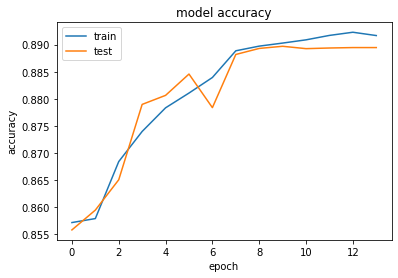

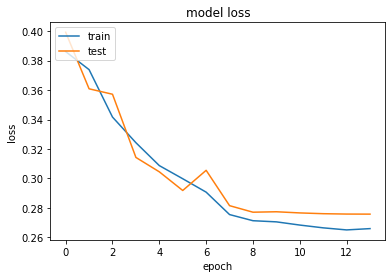

In [31]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()